In [1]:
#Setup and installation
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


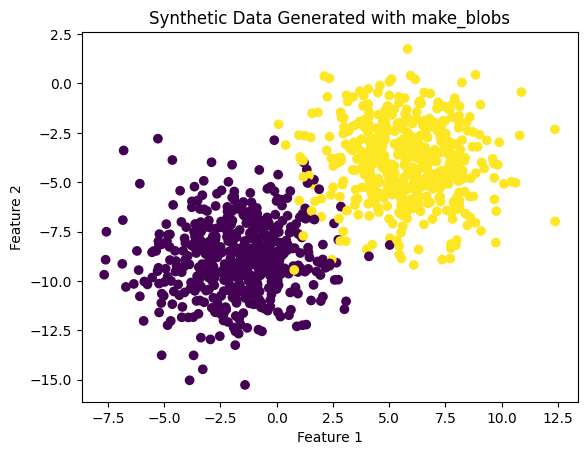

Synthetic dataset created and scaled.


In [2]:
#Importing dependencies and create Synthetic Data with make_blobs
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Generate synthetic data with 2 classes and 2 features using make_blobs
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, cluster_std=2.0, random_state=40)

# Visualize the generated data (optional)
df = pd.DataFrame(X, columns=["Feature 1", "Feature 2"])
df["Target"] = y
plt.scatter(df["Feature 1"], df["Feature 2"], c=df["Target"], cmap="viridis")
plt.title("Synthetic Data Generated with make_blobs")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40)

# Scale the data
scaler = skl.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Synthetic dataset created and scaled.")

In [3]:
#Build a Custom Model-Building Function with Tunable Hyperparameters
def create_model(hp):
    model = tf.keras.models.Sequential()
    # Let the tuner choose the activation function from a list
    activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])

    # First layer: Tune the number of neurons (e.g., from 1 to 10 in steps of 2)
    model.add(tf.keras.layers.Dense(
        units=hp.Int('first_units', min_value=1, max_value=10, step=2),
        activation=activation,
        input_dim=2  # Our data has 2 features
    ))

    # Tune the number of additional hidden layers (between 1 and 6)
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=1, max_value=10, step=2),
            activation=activation
        ))

    # Output layer: Fixed for binary classification
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

In [4]:
#Instantiate and Run the Hyperparameter Tuner
import keras_tuner as kt

# Instantiate the Hyperband tuner with our model-building function
tuner = kt.Hyperband(
    create_model,                # Our custom model-building function
    objective="val_accuracy",    # Optimize for maximum validation accuracy
    max_epochs=20,               # Maximum epochs per trial
    hyperband_iterations=2       # Number of iterations for search initializations
)

print("Hyperband tuner created. Starting hyperparameter search...")

# Run the hyperparameter tuner search
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))
print("Hyperparameter search complete!")

# Retrieve the best hyperparameters and the best performing model
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

# Evaluate the best model on the test set
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")

Trial 60 Complete [00h 00m 13s]
val_accuracy: 0.9440000057220459

Best val_accuracy So Far: 0.984000027179718
Total elapsed time: 00h 07m 54s
Hyperparameter search complete!
8/8 - 1s - 67ms/step - accuracy: 0.9840 - loss: 0.2569
Test Loss: 0.2568720281124115, Test Accuracy: 0.984000027179718



## Reflection on Hyperparameter Tuning with KerasTuner

**1. What advantages does automated hyperparameter tuning using KerasTuner offer compared to manual tuning methods?**

From my experience, using KerasTuner really simplifies the tuning process. Instead of manually guessing which hyperparameters might work best, something that can take a lot of time and doesn’t always lead to great results. KerasTuner lets me run a more organized and strategic search. It systematically tries out different combinations, which saves me a lot of trial and error. I believe this structured approach will lead to a better model performance, especially when I don’t have a indepth experience of which parameters will work best for a given problem.

**2. Describe the trade-offs between an extensive hyperparameter search space and the computational resources required.**

When I expand the search space to include a lot of different hyperparameter options, I open up the possibility of finding a really high performing model which also comes at a cost. More configurations mean longer tuning times and heavier use of computational resources from my observation. So I have to weigh whether the potential performance gains are worth the extra time and processing power. Sometimes, a more focused search is actually more efficient, especially if I already have some idea of which values that are likely to work.

**3. How might small changes to hyperparameters (such as activation functions, neuron counts, or the number of hidden layers) affect the convergence speed and accuracy of a model in real-world scenarios?**

I noticed that even small tweaks to hyperparameters can make a noticeable difference. For example, switching from sigmoid to ReLU often helps the models train faster and avoid vanishing gradients. Adding more neurons or layers might help the model learn more complex patterns, but it can also slow down training and make the model overfit if I’m not careful. These subtle changes influence how quickly and effectively the model learns, and they often show up in both the convergence speed and final accuracy.


In [6]:
#Integrate TensorBoard for Real-Time Visualization

%load_ext tensorboard



import datetime

# Create a log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# (Optional) Retrain the best model with the TensorBoard callback for demonstration
best_model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_test_scaled, y_test), callbacks=[tensorboard_callback])

# Launch TensorBoard (in a Colab cell, uncomment the line below)
# %tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9761 - loss: 0.1260 - val_accuracy: 0.9800 - val_loss: 0.1251
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9823 - loss: 0.1075 - val_accuracy: 0.9760 - val_loss: 0.1173
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9829 - loss: 0.0904 - val_accuracy: 0.9800 - val_loss: 0.1114
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9812 - loss: 0.0922 - val_accuracy: 0.9800 - val_loss: 0.1063
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9817 - loss: 0.0857 - val_accuracy: 0.9800 - val_loss: 0.1024
